## Analysis by Codon Adaptation Index (CAI)

Sharp and Li (Nucleic Acids Res. 1987 Feb 11;15(3):1281-95)

https://en.wikipedia.org/wiki/Codon_Adaptation_Index

CAI measures the deviation of a given protein coding gene sequence with respect to a reference set of genes.

CAI is simply defined as the geometric mean of the weight associated to each codon over the length of the gene sequence (measured in codons).

$$\text{CAI}=\exp \left( \frac{1}{L} \sum_{l=1}^L{\log \left(w_i(l)\right)}\right)$$

where $$w_i=\frac{f_i}{\max(f_j)} \qquad i,j \in [\text{synonymous codons for amino acid}]$$

In [1]:
import os.path
import cPickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.nonparametric.smoothers_lowess import lowess
from Bio.SeqUtils.CodonUsage import CodonAdaptationIndex
from Bio import SeqIO

Reference set of genes (http://downloads.yeastgenome.org/sequence/S288C_reference/orf_dna/), as the default is E. coli, which we do not want to use:

In [2]:
datadir = "../data"
sequencefile = "orf_coding.fasta"
#sequencefile = "orf_coding_all.fasta" # not working (stops at a pseudogene fragment)
sequencefile = os.path.join(datadir, sequencefile)

In [3]:
CAI = CodonAdaptationIndex()

In [4]:
CAI.generate_index(sequencefile)

In [5]:
handle = open(sequencefile, "rU")
record_dict = SeqIO.to_dict(SeqIO.parse(handle, "fasta"))
handle.close()
orf_genomic_dict = {key:str(record_dict[key].seq).lower().replace('t', 'u') for key in record_dict}

Generate a dictionary of all CAIs:

In [6]:
cai_dict = {}
for gene in orf_genomic_dict:
    orf_genomic_dict[gene] = orf_genomic_dict[gene].replace('u', 't')
    cai_dict[gene] = CAI.cai_for_gene(orf_genomic_dict[gene])

In [18]:
pkl.dump(cai_dict, open("../parameters/cai_dict.p", "wb"))

Scatter plot against translation rate (experimental values by Arava et al. (http://www.pnas.org/content/100/7/3889.full):

In [7]:
prot_exp = pkl.load(open("../parameters/prot_arava.p"))
prot_exp = {gene: prot_exp[gene] for gene in prot_exp if prot_exp[gene] > 1e-16}

In [8]:
def scatter_dicts(dict1, dict2, xaxislabel=None, yaxislabel=None, fontsize=None, lws=True, logx=True, logy=True):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    #ax = fig.add_subplot(111)
    ax = plt.subplot(111)
    if logx:
        ax.set_xscale('log')
    else:
        ax.set_xscale('linear')
    if logy:
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    ax.grid(True, linestyle = '-', color = '0.75')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
        if fontsize:
            ax.set_xlabel(xaxislabel, fontsize=fontsize)
            plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)
        if fontsize:
            ax.set_ylabel(yaxislabel, fontsize=fontsize)
            plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    scat = plt.scatter(xs, ys)
    scat.set_alpha(0.2)
    
    # turn on lowess plot
    if lws:
        points = zip(xs, ys)
        sorted_points = sorted(points)
        new_xs = [point[0] for point in sorted_points]
        new_ys = [point[1] for point in sorted_points]
        ylowess = lowess(new_ys, new_xs)[:,1]
        plt.plot(new_xs, ylowess, 'orange', linewidth=4)

    #plt.show()

5165


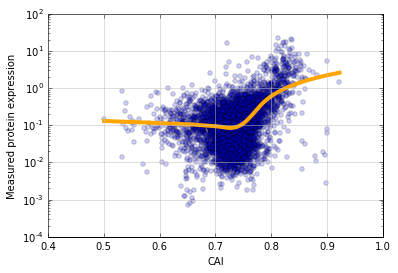

In [9]:
scatter_dicts(cai_dict, prot_exp, xaxislabel="CAI", yaxislabel="Measured protein expression", logx=False)

Scatter plot against translation rate (simulated values, first not normalized by abundance):

In [10]:
prot_speeds = pkl.load(open("../parameters/prot_speeds.p"))

4475


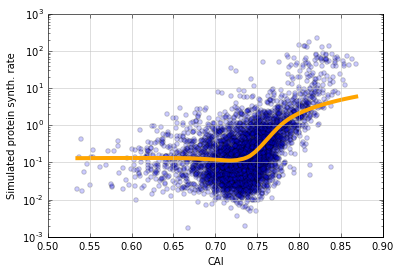

In [11]:
scatter_dicts(cai_dict, prot_speeds, xaxislabel="CAI", yaxislabel="Simulated protein synth. rate", logx=False)

Scatter plot against translation rate (simulated values, now normalized by abundance):

In [12]:
prot_per_transcript_speeds = pkl.load(open("../parameters/prot_per_transcript_speeds.p"))

4475


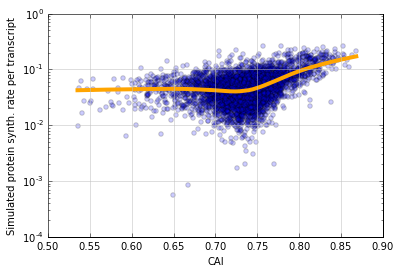

In [13]:
scatter_dicts(cai_dict, prot_per_transcript_speeds, xaxislabel="CAI", 
              yaxislabel="Simulated protein synth. rate per transcript", logx=False)

Scatter plot against translation rate per peptide (simulated values, now normalized by abundance and ORF length):

In [14]:
peptide_speeds = pkl.load(open("../parameters/peptide_speeds.p"))

4475


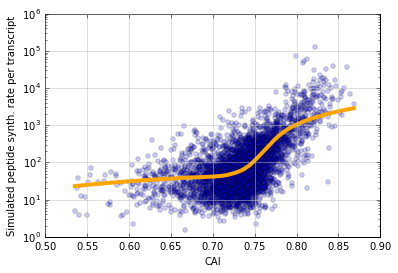

In [15]:
scatter_dicts(cai_dict, peptide_speeds, xaxislabel="CAI", 
              yaxislabel="Simulated peptide synth. rate per transcript", logx=False)

In [16]:
init_rates_plotkin = pkl.load(open("../parameters/init_rates_plotkin.p"))

4716


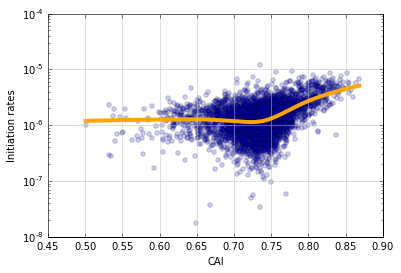

In [17]:
scatter_dicts(cai_dict, init_rates_plotkin, xaxislabel="CAI", 
              yaxislabel="Initiation rates", logx=False)

Some positive correlation despite the initiation rate only being determined by sequence upstream of start codon and CAI only downstream of start codon.